# Tải thư viện

In [1]:
!pip install huggingface_hub transformers
!pip install flash-attn
!pip install accelerate -q
!pip install bitsandbytes -q
!pip install peft trl
!pip install -q datasets
!pip install evaluate
!pip install tqdm
!pip install nltk
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187831595 sha256=58853b28a5a926cae14402bfd8d4d93a45ebf8f9e79533f37ab09d0d77a99c05
  Stored in directory: /root/.cache/pip/wheels/3d/

In [2]:
from datasets import load_dataset, DatasetDict, Features, Value
import re
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
import torch
import accelerate 
import bitsandbytes 
from transformers import AutoTokenizer, TrainingArguments, Trainer, BitsAndBytesConfig, AutoModelForCausalLM, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import numpy as np
import evaluate
import math
import string
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

2025-05-21 11:00:41.292356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747825241.481937      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747825241.537028      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Chuẩn bị dataset

In [3]:
dataset = load_dataset("/kaggle/input/uit-dataset")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
def process_split(split):
    # Chỉ giữ lại 'question' và 'cot_answer'
    columns_to_keep = ['question', 'cot_answer']
    split = split.select_columns(columns_to_keep)
    
    # Trích xuất nội dung sau <ANSWER>
    def extract_answer(example):
        # Thêm flags re.IGNORECASE và xử lý đa dạng định dạng
        match = re.search(r"<ANSWER>\s*:\s*(.*)", example['cot_answer'], re.DOTALL | re.IGNORECASE)
        example['cot_answer'] = match.group(1).strip() if match else ""
        return example
    
    return split.map(extract_answer)

# Áp dụng xử lý cho cả train và validation
dataset = DatasetDict({
    'train': process_split(dataset['train']),
    'validation': process_split(dataset['validation'])
})

# Chia dataset thành tập train 1500 mẫu và valid 500 mẫu
train_dataset = dataset['train'].select(range(1500))  
val_dataset = dataset['validation'].select(range(500))

# Đổi tên cột và tạo DatasetDict
final_dataset = DatasetDict({
    'train': train_dataset.rename_column("cot_answer", "answer"),
    'validation': val_dataset.rename_column("cot_answer", "answer")
})

print(final_dataset)
print(final_dataset['train'][0])

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 500
    })
})
{'question': 'Sinh viên không tham gia công tác thi bị buộc thôi học trong trường hợp nào?', 'answer': 'Sinh viên không tham gia công tác thi nhưng thực hiện một trong các hành vi tiêu cực như thi hộ, tổ chức lấy đề thi ra rồi đưa bài giải vào phòng thi, hoặc gây rối làm mất trật tự tại khu vực thi sẽ bị buộc thôi học.'}


In [5]:
def format_prompt(example):
    prompt = (
        f"<s>[INST] {example['question']} [/INST] "
        f"{example['answer']}</s>"
    )
    return {"text": prompt}

# Xử lý trên từng split
final_dataset = DatasetDict({
    'train': dataset['train']
        .rename_column("cot_answer", "answer")  # Đổi tên cột
        .map(format_prompt)                     # Áp dụng định dạng
        .remove_columns(['question', 'answer']),# Xóa cột gốc
    
    'validation': dataset['validation']
        .rename_column("cot_answer", "answer")
        .map(format_prompt)
        .remove_columns(['question', 'answer'])
})

print(final_dataset)
print(final_dataset['train'][0])

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 500
    })
})
{'text': '<s>[INST] Sinh viên không tham gia công tác thi bị buộc thôi học trong trường hợp nào? [/INST] Sinh viên không tham gia công tác thi nhưng thực hiện một trong các hành vi tiêu cực như thi hộ, tổ chức lấy đề thi ra rồi đưa bài giải vào phòng thi, hoặc gây rối làm mất trật tự tại khu vực thi sẽ bị buộc thôi học.</s>'}


# Load model mistral 7b từ hugging face

In [6]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(token=hf_token)

In [7]:
# # --- 1. Định nghĩa Model ID ---
# model_id = "mistralai/Mistral-7B-Instruct-v0.2"
# MAX_LENGTH = 512

# # --- 2. Định nghĩa Cấu hình Lượng tử hóa (4-bit NF4) ---
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# # === Load model và chia thiết bị ===
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config=bnb_config,
#     device_map=0
# )

# # === Chuẩn bị cho QLoRA training ===
# model = prepare_model_for_kbit_training(model)

# # --- 4. Tải Tokenizer ---
# tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
# tokenizer.pad_token = tokenizer.eos_token

# def tokenize(examples):
#     texts = examples["text"]
#     input_ids_list = []
#     attention_masks = []
#     labels_list = []

#     for text in texts:
#         # Parse thủ công: tách phần instruction và output
#         if "[INST]" not in text or "[/INST]" not in text:
#             raise ValueError("Prompt không đúng định dạng [INST]...[/INST]")

#         instr_start = text.find("[INST]") + len("[INST]")
#         instr_end = text.find("[/INST]")
#         instruction = text[instr_start:instr_end].strip()
#         output = text[instr_end + len("[/INST]"):].strip()

#         full_prompt = f"<s>[INST] {instruction} [/INST] {output}</s>"

#         tokenized = tokenizer(
#             full_prompt,
#             truncation=True,
#             max_length=MAX_LENGTH,
#             padding="max_length"
#         )

#         input_ids = tokenized["input_ids"]
#         attention_mask = tokenized["attention_mask"]

#         # Chỉ huấn luyện phần trả lời: mask phần [INST] ... [/INST]
#         prompt_only = f"<s>[INST] {instruction} [/INST]"
#         prompt_ids = tokenizer(prompt_only, add_special_tokens=False)["input_ids"]
#         prompt_len = len(prompt_ids)

#         labels = [
#             tok_id if i >= prompt_len and tok_id != tokenizer.pad_token_id else -100
#             for i, tok_id in enumerate(input_ids)
#         ]

#         input_ids_list.append(input_ids)
#         attention_masks.append(attention_mask)
#         labels_list.append(labels)

#     return {
#         "input_ids": input_ids_list,
#         "attention_mask": attention_masks,
#         "labels": labels_list
#     }

# # --- 7. Mapping dữ liệu ---
# tokenized_dataset = final_dataset.map(tokenize, batched=True)
# tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# # --- Kiểm tra ---
# print("✅ Mistral-7B-Instruct đã được tải thành công!")

In [8]:
# peft_config = LoraConfig(
#     r=8,
#     lora_alpha=16,
#     target_modules=["q_proj", "v_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM"
# )

# model = get_peft_model(model, peft_config)

In [9]:
# # === Training arguments ===
# training_args = TrainingArguments(
#     output_dir="./qlora-mistral",
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,
#     logging_steps=10,
#     learning_rate=2e-4,
#     bf16=True,
#     save_strategy="epoch",
#     report_to="none",
#     run_name="qlora-mistral",
#     save_total_limit=2,
# )

# # === Data collator ===
# data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Train

In [10]:
# # === Trainer ===
# trainer = Trainer(
#     model=model,
#     train_dataset=tokenized_dataset['train'],
#     eval_dataset=tokenized_dataset['validation'],
#     args=training_args,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

# # === Train ===
# trainer.train()

# # === Save LoRA adapter ===
# model.save_pretrained("./qlora-mistral-adapter-uit")
# tokenizer.save_pretrained("./qlora-mistral-adapter-uit")

In [11]:
# logs = trainer.state.log_history
# train_loss = [log["loss"] for log in logs if "loss" in log]
# steps = [i * training_args.logging_steps for i in range(len(train_loss))]

# plt.plot(steps, train_loss, label="Training Loss")
# plt.xlabel("Steps")
# plt.ylabel("Loss")
# plt.title("Training Loss over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

# Đánh giá

In [12]:
# Đường dẫn đến mô hình đã lưu trên Kaggle
adapter_path = "/kaggle/input/mistral-7b-with-uit-dataset/transformers/default/5/qlora-mistral-adapter-uit"

# Cấu hình lượng tử hóa 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load lại base model với lượng tử hóa 4bit
base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    device_map="auto",
)

# Load lại adapter đã fine-tune
model = PeftModel.from_pretrained(base_model, adapter_path)

# Load tokenizer từ adapter
tokenizer = AutoTokenizer.from_pretrained(adapter_path, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

MAX_LENGTH = 512

def tokenize(examples):
    texts = examples["text"]
    input_ids_list = []
    attention_masks = []
    labels_list = []

    for text in texts:
        # Parse thủ công: tách phần instruction và output
        if "[INST]" not in text or "[/INST]" not in text:
            raise ValueError("Prompt không đúng định dạng [INST]...[/INST]")

        instr_start = text.find("[INST]") + len("[INST]")
        instr_end = text.find("[/INST]")
        instruction = text[instr_start:instr_end].strip()
        output = text[instr_end + len("[/INST]"):].strip()

        full_prompt = f"<s>[INST] {instruction} [/INST] {output}</s>"

        tokenized = tokenizer(
            full_prompt,
            truncation=True,
            max_length=MAX_LENGTH,
            padding="max_length"
        )

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Chỉ huấn luyện phần trả lời: mask phần [INST] ... [/INST]
        prompt_only = f"<s>[INST] {instruction} [/INST]"
        prompt_ids = tokenizer(prompt_only, add_special_tokens=False)["input_ids"]
        prompt_len = len(prompt_ids)

        labels = [
            tok_id if i >= prompt_len and tok_id != tokenizer.pad_token_id else -100
            for i, tok_id in enumerate(input_ids)
        ]

        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        labels_list.append(labels)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_masks,
        "labels": labels_list
    }

tokenized_dataset = final_dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [13]:
eval_args = TrainingArguments(
    output_dir="./eval-output",
    per_device_eval_batch_size=1,
    dataloader_drop_last=False,
    dataloader_num_workers=0,
    eval_accumulation_steps=4,
    fp16=True,
    report_to="none",
)

# Khởi tạo Trainer với hàm compute_metrics
trainer = Trainer(
    model=model,
    args=eval_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)

results = trainer.evaluate()
print(results)

/tmp/ipykernel_35/684128882.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


{'eval_loss': 0.9143011569976807, 'eval_model_preparation_time': 0.0002, 'eval_runtime': 475.5881, 'eval_samples_per_second': 1.051, 'eval_steps_per_second': 1.051}


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


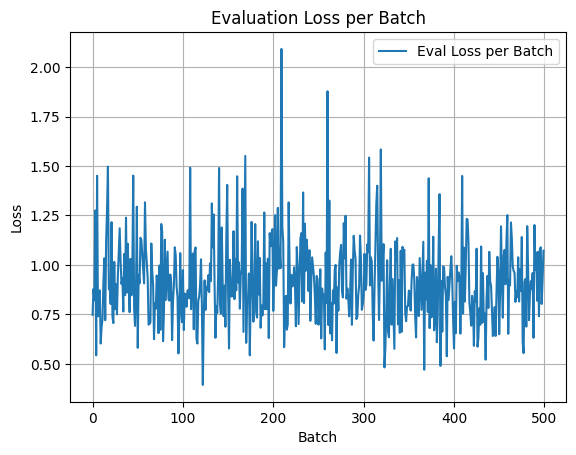

In [14]:
eval_dataloader = trainer.get_eval_dataloader()

model.eval()
losses = []

with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        if isinstance(outputs.loss, torch.Tensor):
            losses.append(outputs.loss.item())

# Vẽ biểu đồ loss
plt.plot(losses, label="Eval Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Evaluation Loss per Batch")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
avg_loss = results["eval_loss"]
perplexity = math.exp(avg_loss)

print(f"Loss: {avg_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")

Loss: 0.9143
Perplexity: 2.4950


In [16]:
# def normalize_answer(s):
#     """Chuẩn hóa chuỗi để so sánh EM công bằng."""
#     def remove_punctuation(text):
#         return text.translate(str.maketrans('', '', string.punctuation))

#     def lower(text):
#         return text.lower()

#     def remove_articles(text):
#         return re.sub(r'\b(a|an|the)\b', ' ', text)

#     def white_space_fix(text):
#         return ' '.join(text.split())

#     return white_space_fix(remove_articles(remove_punctuation(lower(s))))

In [17]:
# def compute_exact_match(references, predictions):
#     em_total = 0
#     for ref, pred in zip(references, predictions):
#         if normalize_answer(ref) == normalize_answer(pred):
#             em_total += 1
#     return em_total / len(references)

# def extract_prompt_and_answer(text):
#     answer_prefix = "### Answer:\n"
#     answer_start = text.find(answer_prefix)
#     if answer_start == -1:
#         raise ValueError("Không tìm thấy phần '### Answer:' trong text.")

#     prompt = text[:answer_start + len(answer_prefix)]
#     answer = text[answer_start + len(answer_prefix):].strip()
#     return prompt, answer

# def compute_em_score(model, tokenizer, dataset):
#     em_scores = []

#     for sample in dataset:
#         full_text = sample["text"]
#         prompt, ground_truth = extract_prompt_and_answer(full_text)

#         inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

#         with torch.no_grad():
#             outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=100,
#                 temperature=0.7,
#                 top_p=0.9,
#                 do_sample=False,
#                 pad_token_id=tokenizer.eos_token_id
#             )

#         generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#         # Tách phần sinh ra sau "### Answer:"
#         answer_start = generated_text.find("### Answer:")
#         if answer_start != -1:
#             predicted_answer = generated_text[answer_start + len("### Answer:"):].strip()
#         else:
#             predicted_answer = generated_text.strip()

#         # So sánh exact match (không phân biệt hoa thường)
#         em = int(predicted_answer.lower() == ground_truth.lower())
#         em_scores.append(em)

#     # Trung bình EM
#     return sum(em_scores) / len(em_scores)

In [18]:
# em_score = compute_em_score(model, tokenizer, final_dataset["validation"])
# print(f"Exact Match (EM) score: {em_score:.4f}")

# Đánh giá với BERTScore

In [19]:
dataset = load_dataset("/kaggle/input/uit-dataset")

In [20]:
def process_split(split):
    # Chỉ giữ lại 'question' và 'cot_answer'
    columns_to_keep = ['question', 'cot_answer']
    split = split.select_columns(columns_to_keep)
    
    # Trích xuất nội dung sau <ANSWER>
    def extract_answer(example):
        # Thêm flags re.IGNORECASE và xử lý đa dạng định dạng
        match = re.search(r"<ANSWER>\s*:\s*(.*)", example['cot_answer'], re.DOTALL | re.IGNORECASE)
        example['cot_answer'] = match.group(1).strip() if match else ""
        return example
    
    return split.map(extract_answer)

# Áp dụng xử lý cho cả train và validation
dataset = DatasetDict({
    'train': process_split(dataset['train']),
    'validation': process_split(dataset['validation'])
})

# Chia dataset thành tập train 1500 mẫu và valid 500 mẫu
train_dataset = dataset['train'].select(range(1500))  
val_dataset = dataset['validation'].select(range(500))

# Đổi tên cột và tạo DatasetDict
final_dataset = DatasetDict({
    'train': train_dataset.rename_column("cot_answer", "answer"),
    'validation': val_dataset.rename_column("cot_answer", "answer")
})

In [21]:
from bert_score import score

preds = []
refs  = []
max_new_tokens = 128

for ex in final_dataset["validation"]:  # Đã chứa 'question' và 'answer'
    q = ex['question']
    ref = ex['answer'].strip()
    
    prompt = f"<s>[INST] {q} [/INST]"
    encoded = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    input_ids = encoded.input_ids.to(model.device)
    attention_mask = encoded.attention_mask.to(model.device)
    
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    pred = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    preds.append(pred.strip())
    refs.append(ref)

# Tính BERTScore
P, R, F1 = score(preds, refs, lang="vi", model_type="vinai/phobert-base",  num_layers=9,  verbose=True)  # Đổi lang="vi" nếu dùng tiếng Việt
print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall:    {R.mean().item():.4f}")
print(f"BERTScore F1:        {F1.mean().item():.4f}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

computing greedy matching.


  0%|          | 0/8 [00:00<?, ?it/s]

done in 2.80 seconds, 178.65 sentences/sec
BERTScore Precision: 0.6620
BERTScore Recall:    0.6398
BERTScore F1:        0.6472


In [24]:
prompts = [
    "Tổng số tín chỉ chương trình đào tạo chính quy của các cơ sở đào tạo ngoài trường có thể được công nhận và chuyển đổi 60% tổng số tín chỉ chương trình đào?",
    "Có thể phân công giảng dạy hoặc mời giảng đối với những giảng viên/trợ giảng nào?",
    "Các đơn vị tham gia phụ trách việc lưu trữ hồ sơ thi là những đơn vị nào?",
    "Giảng viên chính có được đề xuất trợ giảng cho lớp học không?",
    "Phòng Đào tạo Đại học làm gì sau khi nhận được phiếu báo nghỉ dạy từ CBGD?"
]

for i, question in enumerate(prompts):
    print(f"\n================= Sample {i+1} =================")

    # Format prompt theo chuẩn Mistral
    prompt = f"<s>[INST] {question} [/INST]"

    # Tokenize và chuyển sang GPU (nếu có)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Sinh câu trả lời
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Giải mã output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Trích xuất phần trả lời (sau thẻ [/INST])
    answer_start = response.find("[/INST]")
    if answer_start != -1:
        answer_text = response[answer_start + len("[/INST]"):].strip()

        # Dừng lại nếu mô hình sinh thêm prompt khác
        next_inst = answer_text.find("[INST]")
        if next_inst != -1:
            answer_text = answer_text[:next_inst].strip()
    else:
        answer_text = response.strip()

    # In kết quả
    print(answer_text)



================= Sample 1 =================
Có thể phân công giảng dạy hoặc mời giảng đối với các giảng viên/trợ giảng có trình độ tốt nghiệp tối thiểu bằng đại học hoặc có trình độ học vấn tối thiểu chính quy của Trường Đại học Công nghệ Thông tin. Họ không phải là giảng viên hoặc trợ giảng của Trường Đại học Công nghệ Thông tin. Các giảng viên/trợ giảng được phân công hoặc mời giảng dạy đề nghị báo cáo về trình độ, khả năng giảng dạy và học vấn. Các đơn vị liên quan phải đảm bảo giảng viên/trợ giảng có tốt nghiệp trình độ tối thiểu chính quy của Trường và có khả năng giảng dạy và học vấn.

================= Sample 3 =================
Các đơn vị tham gia phụ trách việc lưu trữ hồ sơ thi là Phòng Đào tạo Đại học và Phòng Đào tạo Cơ khí.

================= Sample 4 =================
Giảng viên chính có được đề xuất trợ giảng cho lớp học. Nếu một giảng viên chính có được đề xuất trợ giảng, sẽ được cấp kết quả của việc đề xuất này cho giảng viên chính nhưng không nhận được phí trợ giảng